In [1]:
#import modules
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [11]:

stn = '004'

# Paths
data_path = f'/Users/iw2g24/PycharmProjects/COOKIES/ctd_data/in2026_v01_{stn}/'
data_file = f'in2026_v01_{stn}_data.cnv'     # your data file
header_file = f'in2026_v01_{stn}_header.txt' # your header file

# --- Step 1: Extract column names from header ---
column_names = []
header_path = data_path + header_file

with open(header_path, 'r') as f:
    for line in f:
        if line.startswith('# name'):
            # Grab text after '=' and before ':' (short name)
            name_part = line.split('=')[1].strip()
            short_name = name_part.split(':')[0].strip()
            column_names.append(short_name)
        if line.startswith('*END*'):
            break

print("Extracted column names:")
print(column_names)

# --- Step 2: Find where the data starts in the .cnv file ---
data_path_full = data_path + data_file
data_start = 0
with open(data_path_full, 'r') as f:
    for i, line in enumerate(f):
        if line.startswith('*END*'):
            data_start = i + 1  # data starts on next line
            break

# --- Step 3: Read the data using pandas ---
data = pd.read_csv(
    data_path_full,
    sep=r'\s+',             # future-proof way to handle whitespace
    names=column_names,
    skiprows=data_start,
    comment='#',             # ignore any leftover comment lines
    engine='python'          # recommended when using regex separators
)


# --- Step 4: Inspect the data ---
# print(data.head())
print(data.info())

# Replace '/' with 'per' and spaces with '_'
sanitized_columns = [col.replace('/', 'per').replace(' ', '_') for col in data.columns]

# Apply the sanitized names to the DataFrame
data.columns = sanitized_columns

print("Sanitized column names:")
print(data.columns)

# Define units for each variable (from header info)
units_dict = {
    't090C': 'degC',
    'c0S_per_m': 'S/m',
    'prDM': 'db',
    't190C': 'degC',
    'c1S_per_m': 'S/m',
    'sbeox0Mm_per_L': 'umol/L',
    'sbeox1Mm_per_L': 'umol/L',
    'par': 'umol/m2/s',       # typical PAR units
    'altM': 'm',
    'wetCDOM': 'mg/m3',
    'CStarTr0': '%',
    'flECO_AFL': 'mg/m3',
    'turbWETbb0': 'm^-1/sr',
    'ptempC': 'degC',
    'pumps': 'status',         # could be integer flags
    'bpos': 'index',           # integer
    'nbf': 'count',            # integer
    'sal00': 'PSU',
    'sal11': 'PSU',
    'longitude': 'degrees_east',
    'latitude': 'degrees_north',
    'scan': 'count',
    'timeS': 'seconds',
    'flag': 'unitless'
}

# --- Step 2: Convert DataFrame to xarray Dataset ---
ds = xr.Dataset.from_dataframe(data)

# --- Step 3: Add variable attributes (units) ---
for var in ds.data_vars:
    if var in units_dict:
        ds[var].attrs['units'] = units_dict[var]


# --- Step 4: (Optional) Add global metadata ---
ds.attrs['title'] = f'CTD Cast IN2026_V01_{stn}'
ds.attrs['instrument'] = 'SBE 9 / SBE 43 / ECO sensors'
ds.attrs['location'] = 'Cook Strait / Investigator'
ds.attrs['source'] = 'Raw CTD .cnv converted to NetCDF'

# --- Step 5: Save to NetCDF ---
nc_file = data_path + f'in2026_v01_{stn}.nc'
ds.to_netcdf(nc_file)

print(f"Saved NetCDF file: {nc_file}")


Extracted column names:
['t090C', 'c0S/m', 'prDM', 't190C', 'c1S/m', 'sbeox0Mm/L', 'sbeox1Mm/L', 'par', 'altM', 'wetCDOM', 'CStarTr0', 'flECO-AFL', 'turbWETbb0', 'ptempC', 'pumps', 'bpos', 'nbf', 'sal00', 'sal11', 'longitude', 'latitude', 'scan', 'timeS', 'flag']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296238 entries, 0 to 296237
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   t090C       296238 non-null  float64
 1   c0S/m       296238 non-null  float64
 2   prDM        296238 non-null  float64
 3   t190C       296238 non-null  float64
 4   c1S/m       296238 non-null  float64
 5   sbeox0Mm/L  296238 non-null  float64
 6   sbeox1Mm/L  296238 non-null  float64
 7   par         296238 non-null  float64
 8   altM        296238 non-null  float64
 9   wetCDOM     296238 non-null  float64
 10  CStarTr0    296238 non-null  float64
 11  flECO-AFL   296238 non-null  float64
 12  turbWETbb0  296238 non-null  flo

In [25]:
import os
import xarray as xr

data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/ctd_data/'

# List of stations you want to open
stations = ['001', '002', '003', '004', '005']  # add more if needed

# Dictionary to hold datasets
datasets = {}

for stn in stations:
    file_name = os.path.join(data_dir, f'in2026_v01_{stn}', f'in2026_v01_{stn}.nc')
    if os.path.exists(file_name):
        datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)
        print(f"Opened dataset for station {stn}")
    else:
        print(f"File not found: {file_name}")

# Access a dataset
ds_001 = datasets['001']
ds_002 = datasets['002']
ds_003 = datasets['003']
ds_004 = datasets['004']
ds_005 = datasets['005']
print(ds_005)


Opened dataset for station 001
Opened dataset for station 002
Opened dataset for station 003
Opened dataset for station 004
Opened dataset for station 005
<xarray.Dataset> Size: 54MB
Dimensions:       (index: 270563)
Coordinates:
  * index         (index) int64 2MB 0 1 2 3 4 ... 270559 270560 270561 270562
Data variables: (12/24)
    t090C         (index) float64 2MB ...
    c0Sperm       (index) float64 2MB ...
    prDM          (index) float64 2MB ...
    t190C         (index) float64 2MB ...
    c1Sperm       (index) float64 2MB ...
    sbeox0MmperL  (index) float64 2MB ...
    ...            ...
    sal11         (index) float64 2MB ...
    longitude     (index) float64 2MB ...
    latitude      (index) float64 2MB ...
    scan          (index) int64 2MB ...
    timeS         (index) float64 2MB ...
    flag          (index) float64 2MB ...
Attributes:
    title:       CTD Cast IN2026_V01_005
    instrument:  SBE 9 / SBE 43 / ECO sensors
    location:    Cook Strait / Investigator


In [70]:
depth = ds_001.altM.values
pressure =ds_001.prDM.values
temp1 = ds_001.t090C.values
conductivity = ds_001.c0Sperm.values
salinity =ds_001.sal00.values
time = ds_001.timeS.values
longitude = ds_001.longitude.values
latitude = ds_001.latitude.values

temp2 = ds_001.t190C.values
conductivity2 = ds_001.c1Sperm.values



print('depth shape:', depth.shape)
print('pressure shape:', pressure.shape)
print('temp1 shape:', temp1.shape)
print('conductivity shape:', conductivity.shape)
print('salinity shape:', salinity.shape)
print('time shape:', time.shape)
print('longitude shape:', longitude.shape)
print('latitude shape:', latitude.shape)

depth shape: (81524,)
pressure shape: (81524,)
temp1 shape: (81524,)
conductivity shape: (81524,)
salinity shape: (81524,)
time shape: (81524,)
longitude shape: (81524,)
latitude shape: (81524,)


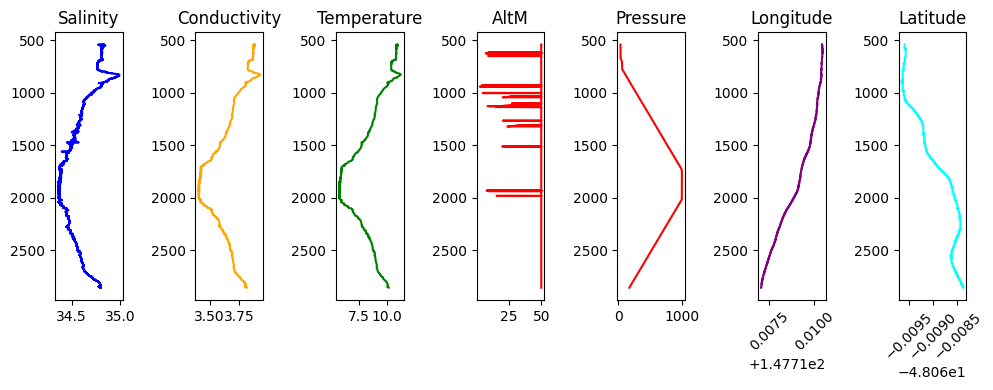

In [71]:
# Create a figure and a set of 1 row, 3 columns of subplots
fig, axs = plt.subplots(1, 7, figsize=(10, 4))
# Plot data on each subplot
axs[0].plot(salinity[13000:-13000], time[13000:-13000], 'blue')
axs[0].set_title('Salinity')
axs[0].invert_yaxis()

axs[1].plot(conductivity[13000:-13000], time[13000:-13000], 'orange')
axs[1].set_title('Conductivity')
axs[1].invert_yaxis()

axs[2].plot(temp1[13000:-13000], time[13000:-13000], 'green')
axs[2].set_title('Temperature')
axs[2].invert_yaxis()

axs[3].plot(depth[13000:-13000], time[13000:-13000], 'red')
axs[3].set_title('AltM')
axs[3].invert_yaxis()

axs[4].plot(pressure[13000:-13000], time[13000:-13000], 'red')
axs[4].set_title('Pressure')
axs[4].invert_yaxis()

axs[5]. plot(longitude[13000:-13000], time[13000:-13000], 'purple')
axs[5].set_title('Longitude')
axs[5].invert_yaxis()
axs[5].tick_params(axis='x', labelrotation=45)


axs[6].plot(latitude[13000:-13000], time[13000:-13000], 'cyan')
axs[6].set_title('Latitude')
axs[6].invert_yaxis()
axs[6].tick_params(axis='x', labelrotation=45)





plt.tight_layout()

In [72]:
longitude_001 = ds_001.longitude.values
latitude_001 = ds_001.latitude.values

longitude_002 = ds_002.longitude.values
latitude_002 = ds_002.latitude.values

longitude_003 = ds_003.longitude.values
latitude_003 = ds_003.latitude.values

longitude_004 = ds_004.longitude.values
latitude_004 = ds_004.latitude.values

longitude_005 = ds_005.longitude.values
latitude_005 = ds_005.latitude.values

print(f'mean lon/lat at 001: ',np.mean(longitude_001[13000:-13000]), '/', np.mean(latitude_001[13000:-13000]))
print(f'mean lon/lat at 002: ', np.mean(longitude_002[13000:-13000]), '/', np.mean(latitude_002[13000:-13000]))
print(f'mean lon/lat at 003: ', np.mean(longitude_003[13000:-13000]), '/', np.mean(latitude_003[13000:-13000]))
print(f'mean lon/lat at 004: ', np.mean(longitude_004[13000:-13000]), '/', np.mean(latitude_004[13000:-13000]))
print(f'mean lon/lat at 005: ', np.mean(longitude_005[13000:-13000]), '/', np.mean(latitude_005[13000:-13000]))


mean lon/lat at 001:  147.71912647791945 / -48.06897281031627
mean lon/lat at 002:  149.27899187964823 / -57.702245342474384
mean lon/lat at 003:  150.01420002586062 / -62.496598014012214
mean lon/lat at 004:  150.0011674515057 / -63.50153670816096
mean lon/lat at 005:  150.02235487526733 / -63.87647666368175


In [73]:
"""
plot for one variable

"""
# pressure_edges = np.zeros(len(pressure) + 1)
# pressure_edges[1:-1] = (pressure[:-1] + pressure[1:]) / 2
# pressure_edges[0] = pressure[0] - (pressure[1] - pressure[0]) / 2
# pressure_edges[-1] = pressure[-1] + (pressure[-1] - pressure[-2]) / 2
#
# fig, ax = plt.subplots(figsize=(7, 4))
#
# pcm = ax.pcolormesh(
#     [0, 1],
#     pressure_edges,
#     temp1[:, None],
#     shading='auto',
#     cmap='viridis',
#     vmin=-1.5, vmax=2
# )
#
# ax.invert_yaxis()
# ax.set_xticks([])
# ax.set_ylabel('Pressure (dBar)')
# ax.set_ylim(0, 600)
# ax.invert_yaxis()
# ax.set_title('Temperature (°C)')
#
# cbar = plt.colorbar(pcm, ax=ax)
# cbar.set_label('°C')
#
# plt.tight_layout()
# plt.show()


'\nplot for one variable\n\n'

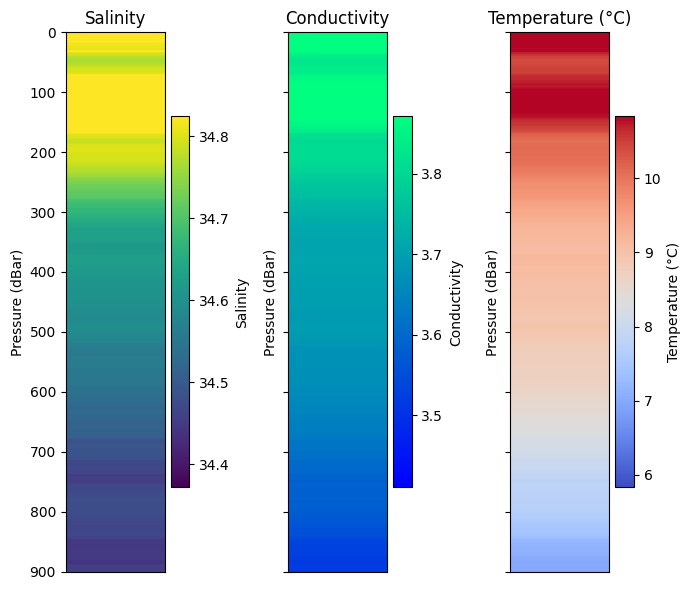

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute pressure edges (required for pcolormesh) ---
pressure_edges = np.zeros(len(pressure) + 1)
pressure_edges[1:-1] = (pressure[:-1] + pressure[1:]) / 2
pressure_edges[0] = pressure[0] - (pressure[1] - pressure[0]) / 2
pressure_edges[-1] = pressure[-1] + (pressure[-1] - pressure[-2]) / 2

# --- Variables to plot ---
variables = [
    (salinity, "Salinity", "viridis", (np.percentile(salinity[13000:-13000], 5)), (np.percentile(salinity[13000:-13000], 95))),
    (conductivity, "Conductivity", "winter", (np.percentile(conductivity[13000:-13000], 5)), (np.percentile(conductivity[13000:-13000], 95))),
    (temp1, "Temperature (°C)", "coolwarm", (np.percentile(temp1[13000:-13000], 5)), (np.percentile(temp1[13000:-13000], 95)))
]

# --- Create subplots ---
fig, axs = plt.subplots(1, 3, figsize=(7, 6), sharey=True)

for ax, (var, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        [0, 1],                 # dummy x-axis
        pressure_edges,         # edges (N+1)
        var[:, None],           # make 2D (N,1)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_title(title)
    ax.set_ylabel("Pressure (dBar)")
    ax.set_ylim(0,900)
    ax.invert_yaxis()

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)

plt.tight_layout()
plt.show()


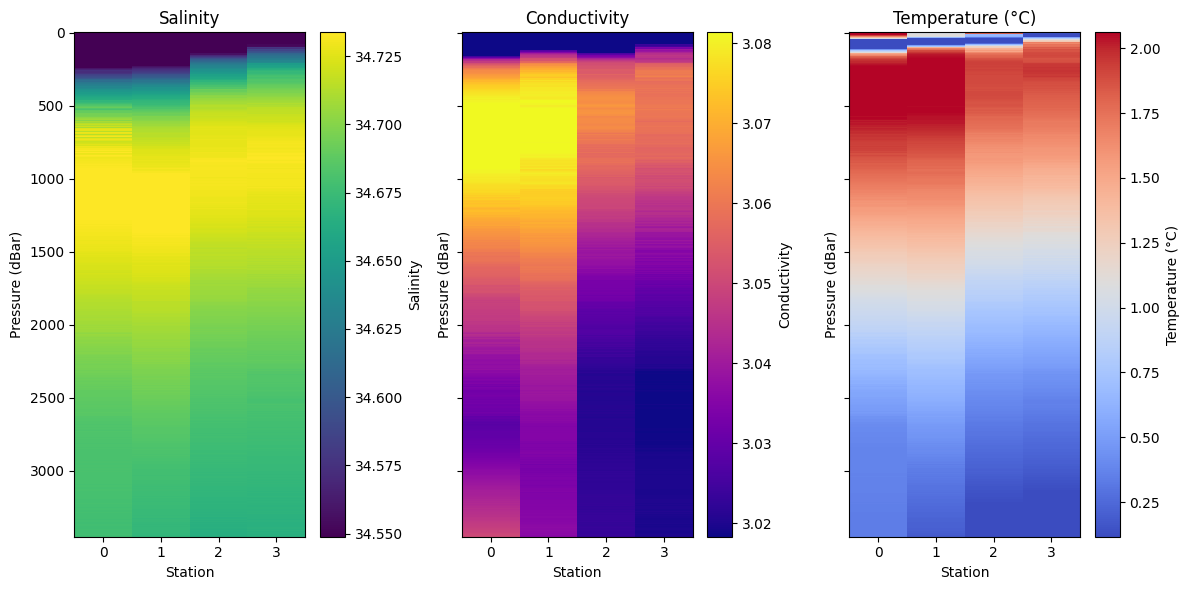

In [79]:
pressures = []
temps = []
sals = []
conds = []

stations = ['002', '003', '004', '005']

for stn in stations:
    ds = datasets[stn]

    p = ds.prDM.values
    t = ds.t090C.values
    s = ds.sal00.values
    c = ds.c0Sperm.values

    # sort by pressure (increasing)
    order = np.argsort(p)
    p = p[order]
    t = t[order]
    s = s[order]
    c = c[order]

    pressures.append(p)
    temps.append(t)
    sals.append(s)
    conds.append(c)


p_min = max(p[0] for p in pressures)
p_max = min(p[-1] for p in pressures)
p_grid = np.linspace(p_min, p_max, 600)

temp_grid = np.vstack([
    np.interp(p_grid, pressures[i], temps[i])
    for i in range(len(stations))
])

sal_grid = np.vstack([
    np.interp(p_grid, pressures[i], sals[i])
    for i in range(len(stations))
])

cond_grid = np.vstack([
    np.interp(p_grid, pressures[i], conds[i])
    for i in range(len(stations))
])

# x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: pressure edges
p_edges = np.zeros(len(p_grid) + 1)
p_edges[1:-1] = (p_grid[:-1] + p_grid[1:]) / 2
p_edges[0] = p_grid[0] - (p_grid[1] - p_grid[0]) / 2
p_edges[-1] = p_grid[-1] + (p_grid[-1] - p_grid[-2]) / 2

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

# variables = [
#     (sal_grid, "Salinity", "viridis", 34.5, 34.75),
#     (cond_grid, "Conductivity", "viridis", 3, 3.05),
#     (temp_grid, "Temperature (°C)", "viridis", -1.5, 2)
# ]

variables = [
    (sal_grid, "Salinity", "viridis",
     np.percentile(sal_grid, 5),
     np.percentile(sal_grid, 95)),

    (cond_grid, "Conductivity", "plasma",
     np.percentile(cond_grid, 5),
     np.percentile(cond_grid, 95)),

    (temp_grid, "Temperature (°C)", "coolwarm",
     np.percentile(temp_grid, 5),
     np.percentile(temp_grid, 95))
]

for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x,
        p_grid,
        var2d.T,        # shape must be (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Pressure (dBar)")

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)

plt.tight_layout()
plt.show()


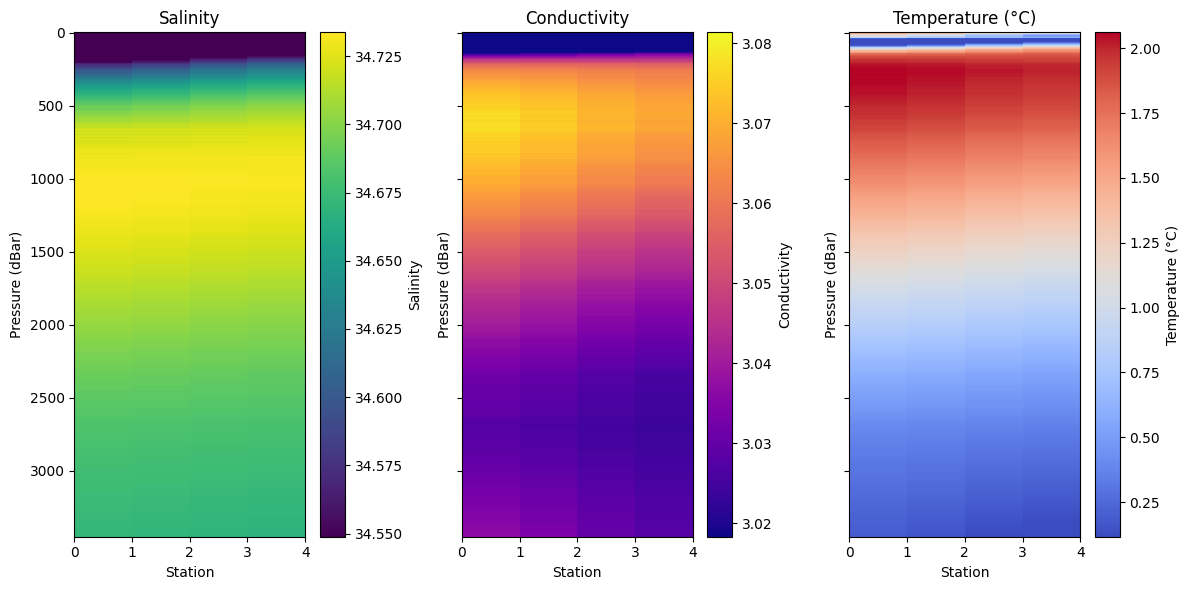

In [82]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Build smoothed transect grids
# -----------------------------

sigma = 2.0

sal_grid_smooth  = gaussian_filter1d(sal_grid,  sigma=sigma, axis=0)
temp_grid_smooth = gaussian_filter1d(temp_grid, sigma=sigma, axis=0)
cond_grid_smooth = gaussian_filter1d(cond_grid, sigma=sigma, axis=0)

# -----------------------------
# 2. Plot smoothed transects
# -----------------------------

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

variables = [
    (sal_grid_smooth,  "Salinity",        "viridis",
     np.percentile(sal_grid, 5),  np.percentile(sal_grid, 95)),

    (cond_grid_smooth, "Conductivity",    "plasma",
     np.percentile(cond_grid, 5), np.percentile(cond_grid, 95)),

    (temp_grid_smooth, "Temperature (°C)", "coolwarm",
     np.percentile(temp_grid, 5), np.percentile(temp_grid, 95))
]

for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,          # station edges
        p_edges,          # pressure edges
        var2d.T,          # (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Pressure (dBar)")

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)

plt.tight_layout()
plt.show()
